<a href="https://colab.research.google.com/github/ArmandoSep/DS-Unit-2-Applied-Modeling/blob/master/module3-permutation-boosting/LS_DS_233_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 3, Module 3*

---


# Permutation & Boosting

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] If you haven't completed assignment #1, please do so first.
- [ ] Continue to clean and explore your data. Make exploratory visualizations.
- [ ] Fit a model. Does it beat your baseline? 
- [ ] Try xgboost.
- [ ] Get your model's permutation importances.

You should try to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.

But, if you aren't ready to try xgboost and permutation importances with your dataset today, that's okay. You can practice with another dataset instead. You may choose any dataset you've worked with previously.

The data subdirectory includes the Titanic dataset for classification and the NYC apartments dataset for regression. You may want to choose one of these datasets, because example solutions will be available for each.


## Reading

Top recommendations in _**bold italic:**_

#### Permutation Importances
- _**[Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/dansbecker/permutation-importance)**_
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

#### (Default) Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

#### Gradient Boosting
  - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
  - [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf), Chapter 8
  - _**[Gradient Boosting Explained](https://www.gormanalysis.com/blog/gradient-boosting-explained/)**_ — Ben Gorman
  - [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html) — Alex Rogozhnikov
  - [How to explain gradient boosting](https://explained.ai/gradient-boosting/) — Terence Parr & Jeremy Howard

In [135]:
import sys

if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/ArmandoSep/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*
    !pip install eli5

     |████████████████████████████████| 112kB 4.4MB/s 


In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

train = pd.read_csv(DATA_PATH+'visa/TrainH1B.csv')
test = pd.read_csv(DATA_PATH+'visa/TestH1B.csv')





## Data visualization

In [0]:
import seaborn as sns

train['CASE_SUBMITTED'] = pd.to_datetime(train['CASE_SUBMITTED'], infer_datetime_format=True)
train['DECISION_DATE'] = pd.to_datetime(train['DECISION_DATE'], infer_datetime_format=True)
train['DECISION_TIME'] = train['DECISION_DATE'] - train['CASE_SUBMITTED']
train['DECISION_TIME'] = train['DECISION_TIME'].dt.days

# Create a column with a boolean if they were certified
train['accepted'] = train['CASE_STATUS'] == 'CERTIFIED'



In [130]:
# accepted = train[train['accepted']]
accepted_counts = train[train['accepted']]
accepted_counts['DECISION_TIME'].value_counts(normalize=True)

6       0.616140
4       0.174386
7       0.106667
5       0.018596
8       0.005965
          ...   
149     0.000351
147     0.000351
133     0.000351
127     0.000351
1042    0.000351
Name: DECISION_TIME, Length: 199, dtype: float64

In [0]:
sns.distplot(accepted_counts);

## Clean data and fit a model

In [14]:
from pandas_profiling import ProfileReport
profile = ProfileReport(train, minimal=True).to_notebook_iframe()

profile

In [455]:
# See mayority class of target 
train['CASE_STATUS'].value_counts(normalize=True)

CERTIFIED    0.579504
DENIED       0.420496
Name: CASE_STATUS, dtype: float64

In [0]:
# Split train into train and val
train, val = train_test_split(train, train_size=0.8, test_size=0.2,
                              stratify=train['CASE_STATUS'], random_state=42)
# Basic cleaning
def wrangle(X):
  # Prevent SettingWithCopyWarning
  X = X.copy()

  # Drop columns with a lot of missing values
  X = X.drop(columns=['Ob', 'EMPLOYER_PROVINCE', 'EMPLOYER_PHONE', 'EMPLOYER_PHONE_EXT',
                              'PUBLIC_DISCLOSURE_LOCATION', 'ORIGINAL_CERT_DATE', 'EMPLOYER_BUSINESS_DBA',
                              'EMPLOYER_ADDRESS'])

  # Properly formate date features
  X['EMPLOYMENT_END_DATE'] = pd.to_datetime(X['EMPLOYMENT_END_DATE'], infer_datetime_format=True)
  X['EMPLOYMENT_START_DATE'] = pd.to_datetime(X['EMPLOYMENT_START_DATE'], infer_datetime_format=True)
  X['CASE_SUBMITTED'] = pd.to_datetime(X['CASE_SUBMITTED'], infer_datetime_format=True)
  X['DECISION_DATE'] = pd.to_datetime(X['DECISION_DATE'], infer_datetime_format=True)

  # Engineer feature: Hoy many days will the person work
  # X['WORK_DURATION_DAYS'] = X['EMPLOYMENT_END_DATE'] - X['EMPLOYMENT_START_DATE']
  # X['WORK_DURATION_DAYS'] = X['WORK_DURATION_DAYS'].dt.days
  X = X.drop(columns=['EMPLOYMENT_END_DATE', 'EMPLOYMENT_START_DATE'])

  # Engineees feature: final wage rate
  X['WAGE_RATE'] = X['WAGE_RATE_OF_PAY_TO'].replace(0.0, X['WAGE_RATE_OF_PAY_FROM'])

  # Engineer feature: time taken for decision
  X['DECISION_TIME'] = X['DECISION_DATE'] - X['CASE_SUBMITTED']
  X['DECISION_TIME'] = X['DECISION_TIME'].dt.days
  X = X.drop(columns=['DECISION_DATE', 'CASE_SUBMITTED'])



  return X


train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [0]:
# Arrange data into X features matrix and y target vector
target = 'CASE_STATUS'
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test

In [458]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.8851626016260162


## Feature importance

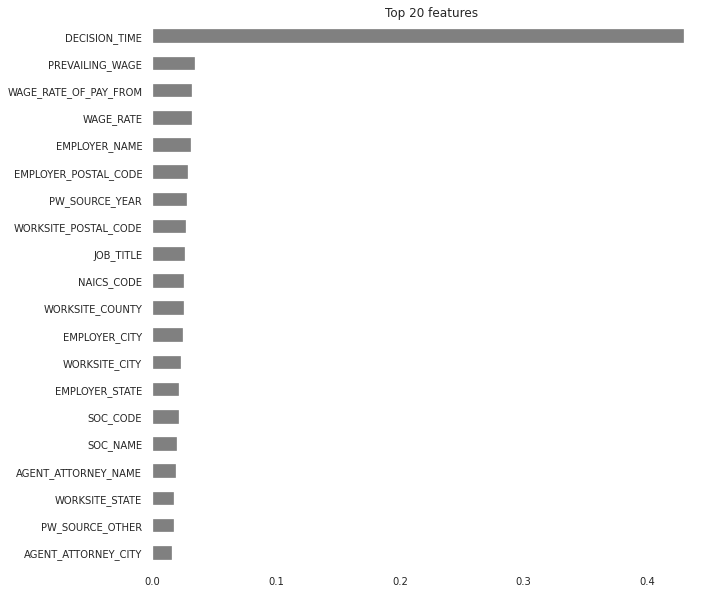

In [459]:
# Get feature importances
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

In [460]:
# Will use permutation importance due that there are some features with high cadinality

transformers = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median')
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [461]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model,
    scoring='accuracy',
    n_iter=5, # Run each permutation 5 times and take the average
    random_state=42
)

permuter.fit(X_val_transformed, y_val)

PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fr

In [462]:
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values(
    ascending=False)

DECISION_TIME                  2.973577e-01
PW_SOURCE_YEAR                 2.439024e-02
AGENT_ATTORNEY_NAME            6.707317e-03
PW_SOURCE_OTHER                5.284553e-03
WAGE_RATE_OF_PAY_TO            4.674797e-03
PREVAILING_WAGE                3.455285e-03
NAICS_CODE                     3.252033e-03
EMPLOYER_CITY                  3.048780e-03
PW_SOURCE                      2.642276e-03
EMPLOYER_COUNTRY               2.642276e-03
AGENT_ATTORNEY_STATE           2.235772e-03
WAGE_RATE_OF_PAY_FROM          2.235772e-03
H1B_DEPENDENT                  2.235772e-03
EMPLOYER_NAME                  2.032520e-03
JOB_TITLE                      2.032520e-03
SUPPORT_H1B                    2.032520e-03
EMPLOYER_STATE                 2.032520e-03
PW_WAGE_LEVEL                  1.829268e-03
SOC_CODE                       1.422764e-03
AGENT_ATTORNEY_CITY            1.422764e-03
EMPLOYER_POSTAL_CODE           1.016260e-03
WAGE_RATE                      1.016260e-03
WORKSITE_POSTAL_CODE           8

In [463]:
eli5.show_weights(
    permuter,
    top=None,
    feature_names=feature_names
)

Weight,Feature
0.2974 ± 0.0254,DECISION_TIME
0.0244 ± 0.0022,PW_SOURCE_YEAR
0.0067 ± 0.0033,AGENT_ATTORNEY_NAME
0.0053 ± 0.0030,PW_SOURCE_OTHER
0.0047 ± 0.0033,WAGE_RATE_OF_PAY_TO
0.0035 ± 0.0030,PREVAILING_WAGE
0.0033 ± 0.0024,NAICS_CODE
0.0030 ± 0.0036,EMPLOYER_CITY
0.0026 ± 0.0021,PW_SOURCE
0.0026 ± 0.0024,EMPLOYER_COUNTRY


Using importances for feature selection

In [464]:
print('Shape before removing features:', X_train.shape)

Shape before removing features: (3934, 41)


In [465]:
minimun_importance = 0
mask = permuter.feature_importances_ > minimun_importance
mask

array([False,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True, False,  True,  True,  True, False, False,
       False, False,  True, False,  True, False,  True,  True,  True,
        True,  True,  True, False,  True, False,  True, False, False,
       False, False,  True,  True,  True])

In [466]:
features = X_train.columns[mask]
X_train_selected = X_train[features]
X_train_selected.shape

(3934, 26)

In [467]:
X_val_selected = X_val[features]

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train_selected, y_train)
print('Validation accuracy', pipeline.score(X_val_selected, y_val))

Validation accuracy 0.8892276422764228


## XGBoost for gradient boosting

In [468]:
from xgboost import XGBClassifier

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    XGBClassifier(n_estimators=500, max_depth=7, random_state=42, n_jobs=-1, objective = 'binary:logitraw')
)

pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['VISA_CLASS', 'EMPLOYER_NAME',
                                      'EMPLOYER_CITY', 'EMPLOYER_STATE',
                                      'EMPLOYER_POSTAL_CODE',
                                      'EMPLOYER_COUNTRY',
                                      'AGENT_REPRESENTING_EMPLOYER',
                                      'AGENT_ATTORNEY_NAME',
                                      'AGENT_ATTORNEY_CITY',
                                      'AGENT_ATTORNEY_STATE', 'JOB_TITLE',
                                      'SOC_CODE', 'SOC_NAME',
                                      'FULL_TIME_POSITION', 'PW_UNIT_OF_PAY',
                                      'PW_WAGE_L...
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
       

In [469]:
# Let's see the validation accuracy

from sklearn.metrics import accuracy_score
y_pred = pipeline.predict(X_val)
print('Validation Accuracy', accuracy_score(y_val, y_pred))

Validation Accuracy 0.8871951219512195


In [470]:
# Let's try different hyperparameters

encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

model = XGBClassifier(
    n_estimators=500, # Number of estimators - with a lot will depend on early stopping
    max_depth=7,   # Depper tress to help with high cardinality features
    learning_rate=0.2,
    n_jobs=-1,
    objective = 'binary:logitraw'
)

eval_set = [(X_train_encoded, y_train),
            (X_val_encoded, y_val)]

model.fit(X_train_encoded, y_train,
          eval_set=eval_set,
          eval_metric='error',
          early_stopping_rounds=50) 

[0]	validation_0-error:0.420437	validation_1-error:0.420732
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 50 rounds.
[1]	validation_0-error:0.119725	validation_1-error:0.140244
[2]	validation_0-error:0.089222	validation_1-error:0.126016
[3]	validation_0-error:0.085918	validation_1-error:0.125
[4]	validation_0-error:0.083122	validation_1-error:0.118902
[5]	validation_0-error:0.080834	validation_1-error:0.117886
[6]	validation_0-error:0.0788	validation_1-error:0.113821
[7]	validation_0-error:0.077783	validation_1-error:0.115854
[8]	validation_0-error:0.07575	validation_1-error:0.11687
[9]	validation_0-error:0.074479	validation_1-error:0.115854
[10]	validation_0-error:0.073716	validation_1-error:0.115854
[11]	validation_0-error:0.069903	validation_1-error:0.11687
[12]	validation_0-error:0.069141	validation_1-error:0.11687
[13]	validation_0-error:0.067616	validation_1-error:0.11687
[14]	

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.2, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=-1,
              nthread=None, objective='binary:logitraw', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [471]:
# binary:logitraw
1-0.104675

0.895325

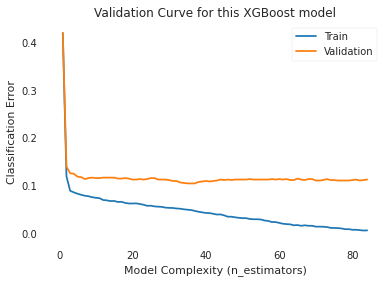

In [472]:
results = model.evals_result()
train_error = results['validation_0']['error']
val_error = results['validation_1']['error']
epoch = list(range(1, len(train_error)+1))
plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.ylabel('Classification Error')
plt.xlabel('Model Complexity (n_estimators)')
plt.title('Validation Curve for this XGBoost model')
#plt.ylim((0.2, 0.10)) # zoom in
plt.legend();